# Интерполяция
## VI.9.32
Согласно переписи население США менялось следующим образом:  \
1910 – 92 228 496 человек,                                   \
1920 – 106 021 537,                                          \
1930 – 123 202 624,                                          \
1940 – 132 164 569,                                          \
1950 – 151 325 798,                                          \
1960 – 179 323 175,                                          \
1970 – 203 211 926,                                          \
1980 – 226 545 805,                                          \
1990 – 248 709 873,                                          \
2000 – 281 421 906.                                          

а) По приведенным данным построить интерполянт в форме Ньютона. Вычислить экстраполированное значение численности населения
США в 2010 году и сравнить с точным значением 308 745 538 человек. 

б) По этим же данным построить сплайн-аппроксимацию, экстраполировать данные на 2010 год, сравнить с точным значением. Какие дополнительные условия для построения сплайна нужно поставить в этом
случае?

в) Какой из результатов оказывается более точным?

In [13]:
import numpy as np
import math
import matplotlib.pyplot as plt
import bisect

In [49]:
x = [     1910,      1920,      1930,      1940,      1950,      1960,      1970,      1980,      1990,      2000 ]
y = [ 92228496, 106021537, 123202624, 132164569, 151325798, 179323175, 203211926, 226545805, 248709873, 281421906 ]
x0     = 2010
y0_ref = 308745538
#x = [0, 0.1, 0.2, 0.3, 0.4]
#y = [5, 2.5, 3, -2.5, -0.2]

## в форме Ньютона

In [50]:
dividedDifferTable = np.zeros([len(x) + 1, len(x)])
dividedDifferTable[0] = x
dividedDifferTable[1] = y
dividedDifferTable = dividedDifferTable.T

In [51]:

for col in range(2, len(dividedDifferTable[0])):
  line_max = dividedDifferTable.shape[0] - col + 1
  for line in range(0, line_max):
    xi = dividedDifferTable[line][0]
    xi_1 = dividedDifferTable[line + col - 1][0]

    fi = dividedDifferTable[line][col - 1]
    fi_1 = dividedDifferTable[line + 1][col - 1]

    dividedDifferTable[line][col] = (fi_1 - fi) / (xi_1 - xi)

In [52]:
N = len(x)
b = np.array([None] * N)
# берутся нижние коэффициенты
for i in range(0, N):
  b[i] = dividedDifferTable[N - 1 - i][i + 1]
print("b: ", b)

b:  [281421906.0 3271203.3 52739.825 1952.9626666666668 51.386312499999995
 1.3751173333333333 0.051623095833333334 0.0017046828571428572
 3.832927703373017e-05 5.099328042328045e-07]


In [53]:
def lower_Newton(x, xi, bi):
  res = bi[0]
  N = len(bi)
  for i in range(1, N):
    cur = bi[i]
    for k in range(0, i):
      cur = cur * (x - xi[N - k - 1])
    res = res + cur
  return res

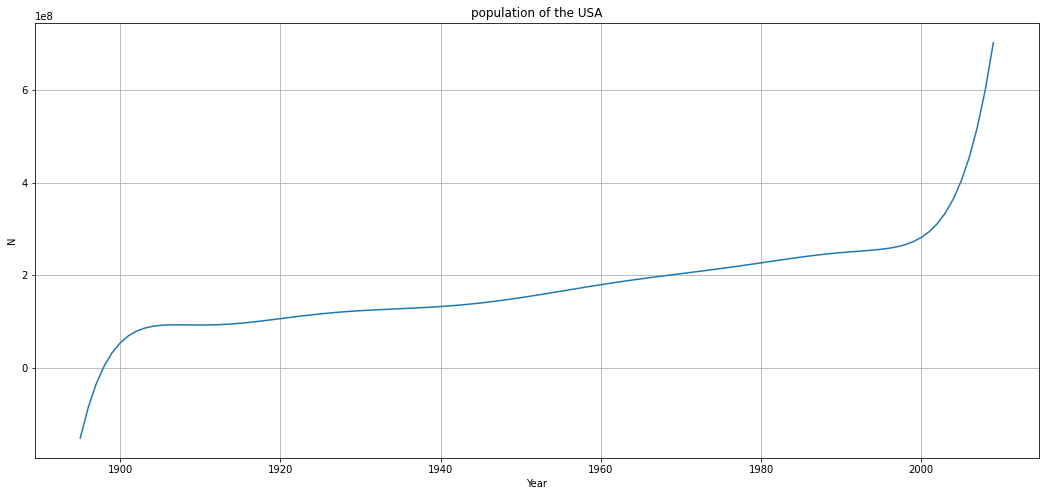

F(2010) = 827906509.0000001


In [54]:
k = np.arange(start=1895, stop=2010, step=1)

plt.figure(figsize=[18, 8])
plt.grid()
plt.title("population of the USA")
plt.ylabel('N')
plt.xlabel('Year')
plt.plot(k, list(map(lambda i : lower_Newton(i, x, b), k)))
plt.show()
print("F(2010) =", lower_Newton(2010, x, b))

## Сплайн

$ S''(1910) = 0 $ \
$ S''(2000) = 0 $

In [92]:
splines = np.zeros([len(x), 4])
nu_1 = 0
nu_2 = 0

# построим СЛУ для нахождения коэффициентов с.
h_sistem = np.zeros([len(x), len(x)])
h_sistem[0][0] = h_sistem[len(x) - 1][len(x) - 1] = 1
for line in range(1, len(x) - 1):
  for col in range(line - 1, line + 2):
    if line == col:
      h_sistem[line][col] = 2 * (x[line + 1] - x[line - 1])
    elif line == col - 1:
      h_sistem[line][col] = x[line + 1] - x[line]
    elif line == col + 1:
      h_sistem[line][col] = x[line] - x[line - 1]

h_sistem_b = np.zeros([len(x), 1])
h_sistem_b[0] = nu_1
h_sistem_b[len(x) - 1] = nu_2
for i in range(1, len(x) - 1):
  h_sistem_b[i] = (y[i + 1] - y[i]) / 10.0 - (y[i] - y[i - 1]) / 10.0

c = np.linalg.solve(h_sistem, h_sistem_b).T[0]
a = y
d = [c[0] / 10.0] + list(map(lambda i: (c[i] - c[i - 1]) / 10.0, np.arange(start=1, stop=len(x))))
b = [a[0] / 10.0 + c[0] * 10.0 / 3.0] + list(map(lambda i: (y[i] - y[i - 1]) / 10.0 + c[i] * 10.0 / 3.0 + c[i - 1] * 10.0 / 6.0, np.arange(start=1, stop=len(x))))

In [95]:
def calculate_value_with_spline(x, xi, ai, bi, ci, di):
  i = bisect.bisect_right(xi, x)
  if i >= len(xi): i = len(xi) - 1
  if i <= 0: i = 1

  return ai[i] + bi[i] * (x - xi[i]) + ci[i] /2.0 * (x - xi[i])**2 + di[i] / 6.0 * (x - xi[i])**3

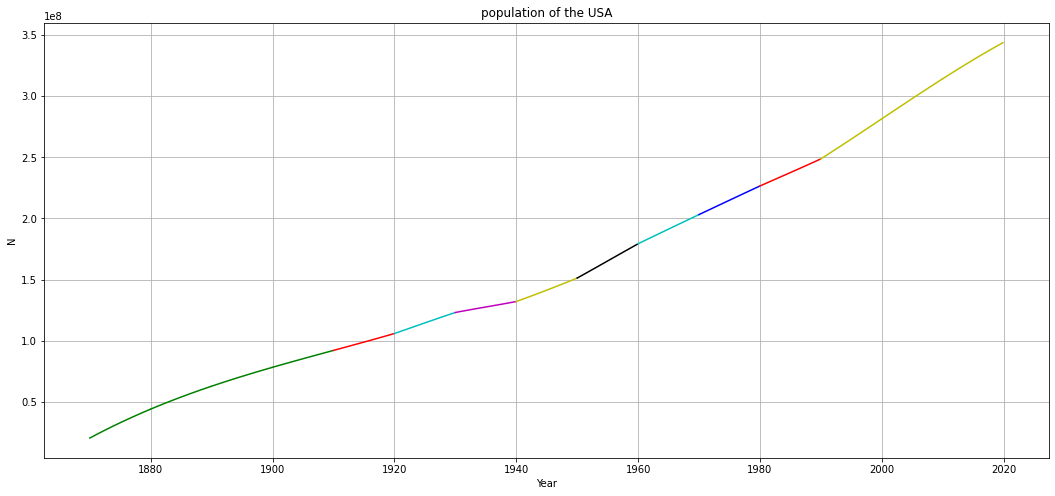

F(2010) = 314133939.0
real    = 308745538


In [106]:
plt.figure(figsize=[18, 8])
plt.grid()
plt.title("population of the USA")
plt.ylabel('N')
plt.xlabel('Year')
colours = [ 'b', 'g', 'r', 'c', 'm', 'y', 'k', 'c', 'b', 'r', 'y' ]

for i in range(-2, 13):
  if i >= len(x): color = colours[len(x)]
  elif i <= 0: color = colours[1]
  else: color = colours[i]

  k = np.arange(start=1890 + i * 10, stop=1890 + (i + 1) * 10, step=0.1)
  plt.plot(k, list(map(lambda i : calculate_value_with_spline(i, x, a, b, c, d), k)), color)

plt.show()

print("F(2010) =", calculate_value_with_spline(2010, x, a, b, c, d))
print("real    = 308745538")